In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to PyTorch tensor
])

# Load the MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select one image and its label (e.g., the first one)
mnist_image, label = mnist_dataset[0]  # mnist_image shape: [1, 28, 28]


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6474348.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 358929.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2645038.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1242695.94it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
import torch.nn.functional as F

def generate_2D_gaussian_splatting(kernel_size, sigma_x, sigma_y, rho, coords, colours, image_size=(28, 28), channels=1, device="cpu"):
    batch_size = colours.shape[0]

    # Reshape sigma and rho
    sigma_x = sigma_x.view(batch_size, 1, 1)
    sigma_y = sigma_y.view(batch_size, 1, 1)
    rho = rho.view(batch_size, 1, 1)

    # Create covariance matrices
    covariance = torch.stack(
        [torch.stack([sigma_x**2, rho * sigma_x * sigma_y], dim=-1),
         torch.stack([rho * sigma_x * sigma_y, sigma_y**2], dim=-1)],
        dim=-2
    )

    # Check for positive semi-definiteness
    determinant = (sigma_x**2) * (sigma_y**2) - (rho * sigma_x * sigma_y)**2
    if (determinant <= 0).any():
        raise ValueError("Covariance matrix must be positive semi-definite")

    inv_covariance = torch.inverse(covariance)

    # Create grid for kernel
    start = torch.tensor([-5.0], device=device).view(-1, 1)
    end = torch.tensor([5.0], device=device).view(-1, 1)
    base_linspace = torch.linspace(0, 1, steps=kernel_size, device=device)
    ax_batch = start + (end - start) * base_linspace

    # Create meshgrid
    ax_batch_expanded_x = ax_batch.unsqueeze(-1).expand(-1, -1, kernel_size)
    ax_batch_expanded_y = ax_batch.unsqueeze(1).expand(-1, kernel_size, -1)
    xx, yy = ax_batch_expanded_x, ax_batch_expanded_y
    xy = torch.stack([xx, yy], dim=-1)

    # Compute Gaussian kernel
    z = torch.einsum('b...i,b...ij,b...j->b...', xy, -0.5 * inv_covariance, xy)
    kernel = torch.exp(z) / (2 * torch.tensor(np.pi, device=device) * torch.sqrt(torch.det(covariance)).view(batch_size, 1, 1))

    # Normalize the kernel
    kernel_max = kernel.view(batch_size, -1).max(dim=1, keepdim=True)[0].view(batch_size, 1, 1)
    kernel_normalized = kernel / kernel_max

    # Reshape kernel to match channels
    kernel_reshaped = kernel_normalized.repeat(1, channels, 1).view(batch_size * channels, kernel_size, kernel_size)
    kernel_channels = kernel_reshaped.unsqueeze(0).reshape(batch_size, channels, kernel_size, kernel_size)

    # Calculate padding
    pad_h = image_size[0] - kernel_size
    pad_w = image_size[1] - kernel_size

    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")

    padding = (pad_w // 2, pad_w // 2 + pad_w % 2,
               pad_h // 2, pad_h // 2 + pad_h % 2)

    kernel_padded = F.pad(kernel_channels, padding, "constant", 0)

    # Create affine transformation
    b, c, h, w = kernel_padded.shape
    theta = torch.zeros(b, 2, 3, dtype=torch.float32, device=device)
    theta[:, 0, 0] = 1.0
    theta[:, 1, 1] = 1.0
    theta[:, :, 2] = coords

    # Apply affine transformation
    grid = F.affine_grid(theta, size=(b, c, h, w), align_corners=True)
    kernel_transformed = F.grid_sample(kernel_padded, grid, align_corners=True)

    # Multiply by color values
    colours_reshaped = colours.unsqueeze(-1).unsqueeze(-1)
    final_image_layers = colours_reshaped * kernel_transformed

    # Sum layers to form final image
    final_image = final_image_layers.sum(dim=0)
    final_image = torch.clamp(final_image, 0, 1)
    final_image = final_image.permute(1, 2, 0)  # Shape: [H, W, channels]

    return final_image


In [4]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)]))
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.autograd.Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window



def ssim(img1, img2, window_size=11, size_average=True):


    # Assuming the image is of shape [N, C, H, W]
    (_, _, channel) = img1.size()

    img1 = img1.unsqueeze(0).permute(0, 3, 1, 2)
    img2 = img2.unsqueeze(0).permute(0, 3, 1, 2)


    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    SSIM_numerator = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))
    SSIM_denominator = ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    SSIM = SSIM_numerator / SSIM_denominator

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    l1loss = nn.L1Loss()
    return (1 - lambda_param) * l1loss(pred, target) + lambda_param * d_ssim_loss(pred, target)

In [3]:
def give_required_data(input_coords, image_size):

  # normalising pixel coordinates [-1,1]
  coords = torch.tensor(input_coords / [image_size[0],image_size[1]], device=device).float()
  center_coords_normalized = torch.tensor([0.5, 0.5], device=device).float()
  coords = (center_coords_normalized - coords) * 2.0

  # Fetching the colour of the pixels in each coordinates
  colour_values = [image_array[coord[1], coord[0]] for coord in input_coords]
  colour_values_np = np.array(colour_values)
  colour_values_tensor =  torch.tensor(colour_values_np, device=device).float()

  return colour_values_tensor, coords

Epoch 1/500, Loss: 0.07118282467126846


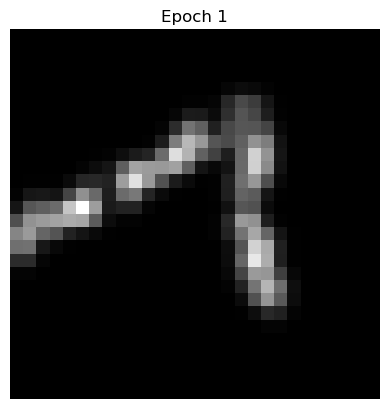

Epoch 51/500, Loss: 0.001022644923068583


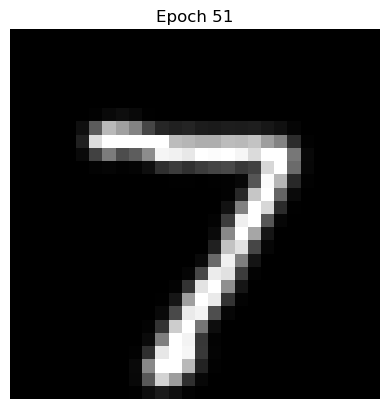

Epoch 101/500, Loss: 0.0006023799651302397


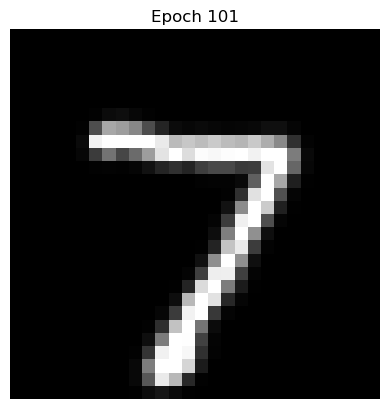

Epoch 151/500, Loss: 0.000602307147346437


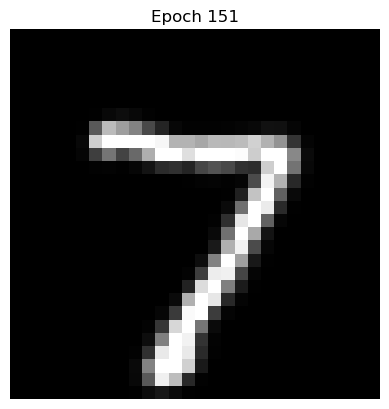

Epoch 201/500, Loss: 0.0007240751874633133


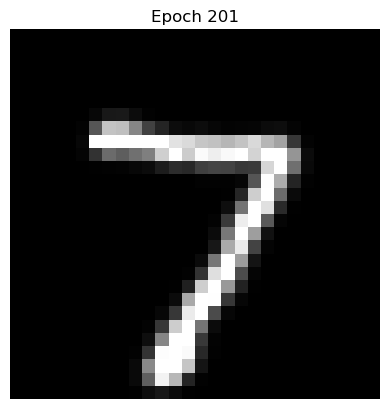

Epoch 251/500, Loss: 0.0010100454092025757


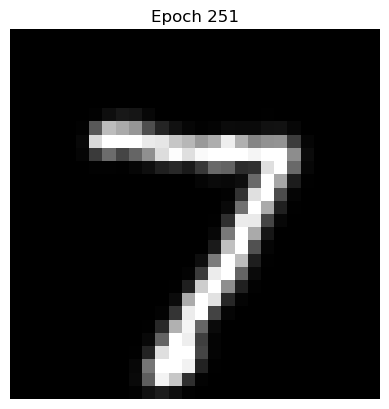

Epoch 301/500, Loss: 0.0007939383503980935


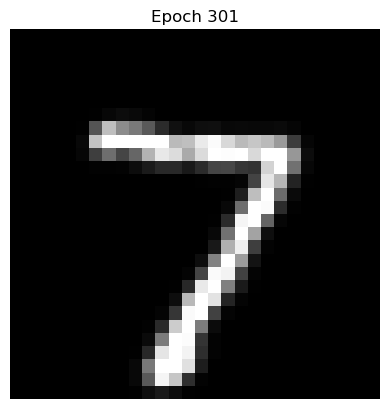

Epoch 351/500, Loss: 0.0007783272303640842


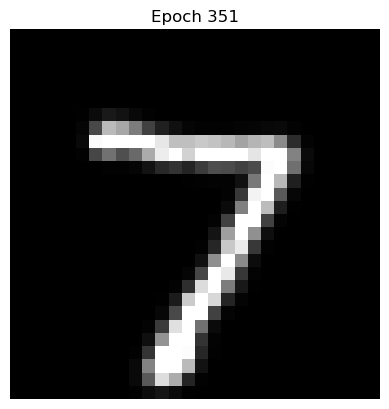

Epoch 401/500, Loss: 0.0007706644828431308


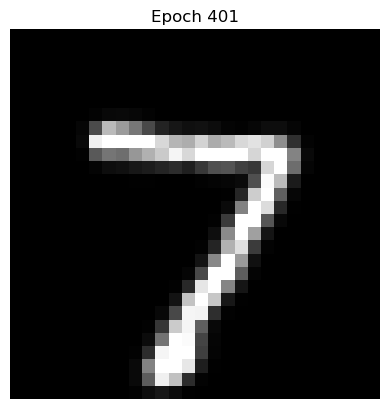

Epoch 451/500, Loss: 0.0005143968155607581


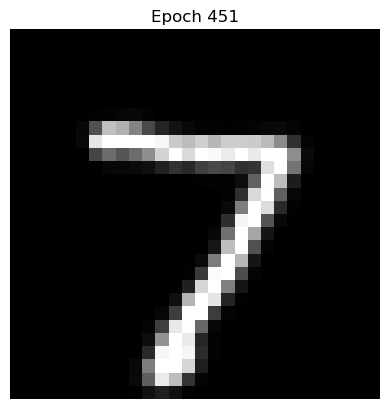

Epoch 500/500, Loss: 0.001209788490086794


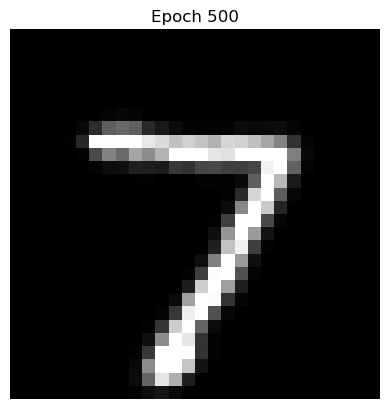

In [9]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
from torch.optim import Adam

# Prepare the image
mnist_image = mnist_image.to(device)  # Shape: [1, 28, 28]
mnist_image = mnist_image.squeeze(0)  # Shape: [28, 28]
image_size = mnist_image.shape  # (28, 28)
target_tensor = mnist_image  # Ground truth

# Get non-zero pixel coordinates and values
# Filter out background pixels from mnist_image
coords = torch.nonzero(mnist_image > 0.1)  # coords shape: [num_coords, 2] for (row, column) pairs

# Set the number of random coordinates you want to choose
n = 50

# Ensure n is not larger than the number of available coordinates
n = min(n, coords.shape[0])

# Select n random indices from the available coordinates
random_indices = torch.randperm(coords.shape[0])[:n]

# Get the randomly selected coordinates
coords = coords[random_indices]
num_samples = coords.shape[0]


# Get pixel values at these coordinates
colour_values = mnist_image[coords[:, 0], coords[:, 1]].unsqueeze(1)  # Shape: [num_samples, 1]

# Normalize coordinates to [-1, 1]
coords_normalized = coords.float()
coords_normalized[:, 0] = (coords_normalized[:, 0] / (image_size[0] - 1)) * 2 - 1
coords_normalized[:, 1] = (coords_normalized[:, 1] / (image_size[1] - 1)) * 2 - 1
coords_normalized = coords_normalized.to(device)

# Initialize Gaussian parameters
sigma_values = torch.rand(num_samples, 2, device=device) * 0.5 + 0.5  # Sigmas between 0.5 and 1.0
rho_values = torch.zeros(num_samples, 1, device=device)  # No correlation
alpha_values = torch.ones(num_samples, 1, device=device)  # Full opacity
W_values = torch.cat([sigma_values, rho_values, alpha_values, colour_values, coords_normalized], dim=1)


# Create parameter for optimization
W = nn.Parameter(W_values)
optimizer = Adam([W], lr=0.1)

# Training loop parameters
num_epochs = 500
loss_history = []
KERNEL_SIZE = 9  # Adjusted for smaller image
channels = 1  # Grayscale

# Training loop
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()

    output = W

    batch_size = output.shape[0]

    sigma_x = torch.sigmoid(output[:, 0])
    sigma_y = torch.sigmoid(output[:, 1])
    rho = torch.tanh(output[:, 2])
    alpha = torch.sigmoid(output[:, 3])
    colours = torch.clamp(output[:, 4:5], 0, 1)
    pixel_coords = output[:, 5:7]

    colours_with_alpha = colours * alpha.view(batch_size, 1)
    g_tensor_batch = generate_2D_gaussian_splatting(
        KERNEL_SIZE,
        sigma_x,
        sigma_y,
        rho,
        pixel_coords,
        colours_with_alpha,
        image_size,
        channels=channels,
        device=device
    )

    # Compute loss
    loss = nn.MSELoss()(g_tensor_batch.squeeze(), target_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

        # Visualize the reconstructed image
        plt.imshow(g_tensor_batch.cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title(f'Epoch {epoch+1}')
        plt.axis('off')
        plt.show()


In [4]:
# Save the Gaussian representation
torch.save(W.detach().cpu(), 'mnist_gaussian_representation.pt')
print("Gaussian representation saved to 'mnist_gaussian_representation.pt'")


Gaussian representation saved to 'mnist_gaussian_representation.pt'


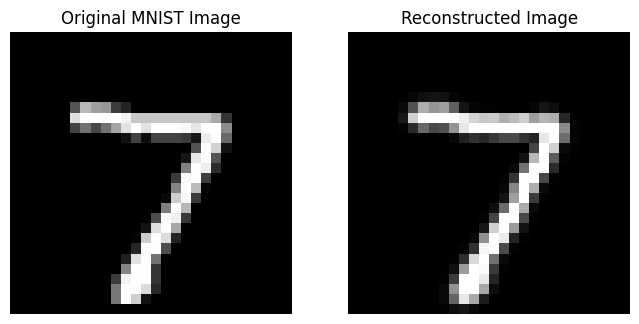

In [5]:
# Generate the final image using the trained parameters
with torch.no_grad():
    sigma_x = torch.sigmoid(W[:, 0])
    sigma_y = torch.sigmoid(W[:, 1])
    rho = torch.tanh(W[:, 2])
    alpha = torch.sigmoid(W[:, 3])
    colours = torch.clamp(W[:, 4:5], 0, 1)
    pixel_coords = W[:, 5:7]
    colours_with_alpha = colours * alpha.view(batch_size, 1)

    final_image = generate_2D_gaussian_splatting(
        KERNEL_SIZE,
        sigma_x,
        sigma_y,
        rho,
        pixel_coords,
        colours_with_alpha,
        image_size,
        channels=channels,
        device=device
    )

# Plot original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(target_tensor.cpu().numpy(), cmap='gray')
plt.title('Original MNIST Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_image.cpu().numpy().squeeze(), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()